## Imports

In [127]:
import itertools
import math
from collections import Counter

from eli5 import show_weights

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pprint import *

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
import lightgbm as lgb

# Import Nike Data

In [37]:
nike = pd.read_csv("data/nike.csv", index_col = 0)

print("Basic information about our Nike.com dataset:\n")
print(nike.info())
print(
    "\n\nA little more summary info about our data "
    "(there\nare only a few columns in our data, making "
    "this\neasy to inspect):\n\n",
    nike.describe(),
)
print("\n\nAnd, the first few rows of our data:")
display(nike.head(3))

Basic information about our Nike.com dataset:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 0 to 1367
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          409 non-null    object 
 1   title          1368 non-null   object 
 2   subtitle       1367 non-null   object 
 3   num_colors     1368 non-null   object 
 4   price          1366 non-null   object 
 5   reduced_price  579 non-null    object 
 6   url            1368 non-null   object 
 7   description    1340 non-null   object 
 8   colors         840 non-null    object 
 9   n_reviews      1271 non-null   float64
 10  avg_stars      1271 non-null   float64
dtypes: float64(2), object(9)
memory usage: 128.2+ KB
None


A little more summary info about our data (there
are only a few columns in our data, making this
easy to inspect):

          n_reviews    avg_stars
count  1271.000000  1271.000000
mean     73.042486     3.432966


,label,title,subtitle,num_colors,price,reduced_price,url,description,colors,n_reviews,avg_stars
0,Best Seller,Air Jordan 1 Mid,Shoes,2 Colors,$125,NaN,https://www.nike.com/t/air-jordan-1-mid-shoes-...,"Inspired by the original AJ1, the Air Jordan 1...",Black/White/Fire Red; Black/Black/Black,2161.0,4.9
1,Best Seller,Nike Blazer Mid '77 Vintage,Women's Shoes,3 Colors,$105,NaN,https://www.nike.com/t/blazer-mid-77-vintage-w...,Styled for the ‘70s. Loved in the ‘80s. Classi...,White/White/Peach/White; White/Sail/Peach/Blac...,519.0,4.8
2,Coming Soon,Nike Dunk Low Retro,Men's Shoes,1 Color,$110,NaN,https://www.nike.com/t/dunk-low-retro-mens-sho...,Created for the hardwood but taken to the stre...,NaN,NaN,NaN


**Change `price` and `num_colors` to numeric**

In [38]:
nike['price'] = nike['price'].str.replace('$','').astype(np.float64)
nike['num_colors'] = nike['num_colors'].str.replace(' Colors','').str.replace(' Color','').astype(np.float64)

/var/folders/kl/zzq83xsx65s2p501hz1mwvlw0000gn/T/ipykernel_2647/405425822.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  nike['price'] = nike['price'].str.replace('$','').astype(np.float64)


**Filling missing entries for `n_reviews` and `avg_stars` with zeros**

In [39]:
nike['n_reviews'].fillna(0, inplace = True)
nike['avg_stars'].fillna(0, inplace = True)

**Drop gift card items**

In [50]:
nike = nike[~nike['title'].str.contains("gift card", na = False, case = False)]

**Count missing entries for each feature**

In [107]:
nike.isna().sum()

label            958
title              0
subtitle           0
num_colors         0
price              0
reduced_price    787
url                0
description       28
colors           528
n_reviews          0
avg_stars          0
category           0
purpose            0
dtype: int64

## Preprocess `subtitle` feature

In [55]:
pprint(list(nike.subtitle.unique())[100: 120])

["Little Kids' Easy On/Off Shoes",
 'Artificial-Turf Soccer Shoes',
 'Basketball Shoe',
 "Men's Trail Running Shoes",
 'Baby/Toddler Shoe',
 "Little/Big Kids' Road Running Shoes",
 "Women's Easy On/Off Road Running Shoes",
 'Custom Firm Ground Soccer Cleat',
 "Big Kids' Boots",
 "Little/Big Kids' Turf Soccer Shoes",
 "Men's Duckboot",
 'Men’s Training Shoes',
 'Custom Shoes',
 "Little Kids' Shoe ",
 "Women's Road Racing Shoes",
 'Indoor/Court Soccer Shoes',
 'Baseball Cleat',
 "Little/Big Kids' Cleats",
 "Women's Custom Shoes",
 "Women's HIIT Class Shoes"]


In [41]:
nike.loc[nike['subtitle'].str.contains("Men's", na = False, case = True), 'category'] = "Men's"
nike.loc[nike['subtitle'].str.contains("Women's", na = False, case = True), 'category'] = "Women's"
nike.loc[nike['subtitle'].str.contains("Kids", na = False, regex = True), 'category'] = "Kids"
nike.loc[nike['subtitle'].str.contains("toddler", na = False, case = False), 'category'] = "Infant's"
nike['category'].fillna("Men's", inplace = True) 

categories = nike['category'].value_counts(normalize = True)
categories

Men's       0.476608
Kids        0.247076
Women's     0.193713
Infant's    0.082602
Name: category, dtype: float64

In [93]:
nike['purpose'] = nike['subtitle']
nike = nike.replace({'purpose' : {".*Easy On/Off.*": "Lifestyle",
                                   ".*Custom.*" : "Custom",
                                   ".*Cleats.*": "Soccer",
                                   ".*style.*" : "Lifestyle",
                                   ".*Running.*" : "Running",
                                   ".*Basketball.*" : "Basketball",
                                   ".*Baseball.*" : "Baseball",
                                   ".*Indoor Court.*": "Training",
                                   ".*Endurance Class.*": "Training",
                                   ".*Volleyball.*" : "Volleyball",
                                   ".*HIIT.*" : "Training",
                                   ".*Skate.*" : "Skate",
                                   ".*Football.*" : "Football",
                                   ".*Boot.*" : "Boot",
                                   ".*Duckboot.*": "Boot",
                                   ".*Cycling.*" : "Cycling",
                                   ".*Sandal.*" : "Sandal",
                                   ".*Slide.*" : "Sandal",
                                   ".*Slip$" : "Sandal",
                                   ".*Slipper.*": "Sandal",
                                   ".*Mule.*": "Sandal",
                                   ".*Softball.*" : "Softball",
                                   ".*Golf.*" : "Golf",
                                   ".*Soccer.*" : "Soccer",
                                   ".*Tennis.*" : "Tennis",
                                   ".*Training.*" : "Training",
                                   ".*Weightlifting.*": "Weightlifting",
                                   ".*Racing.*" : "Racing",
                                   ".*Track.*" : "Track",
                                   ".*One Star.*": "Lifestyle"   
                                  }}, regex = True)
nike = nike.replace({'purpose' : {"Shoe[s]{0,1}": "Lifestyle",
                                  "Women's Shoe[s]{0,1}": "Lifestyle",
                                  "Men's Shoe[s]{0,1}": "Lifestyle",
                                  ".*Kids' Shoe[s]{0,1}": "Lifestyle"
                                  }}, regex = True)
nike.loc[nike['purpose'].str.contains("Lifestyle", na = False, case = True), 'purpose'] = "Lifestyle"

In [101]:
unique_cat = list(nike['category'].unique())
unique_purpose = list(nike['purpose'].unique())

print(f"There are {len(unique_cat)} unique categories and {len(unique_purpose)} unique purposes")
print(unique_cat)
pprint(nike['purpose'].value_counts())

There are 4 unique categories and 19 unique purposes
["Men's", "Women's", 'Kids', "Infant's"]
Lifestyle        782
Running          116
Soccer           106
Basketball        62
Sandal            61
Custom            50
Training          43
Boot              38
Golf              25
Skate             24
Track             19
Tennis            14
Baseball           9
Racing             7
Cycling            4
Football           2
Softball           2
Weightlifting      1
Volleyball         1
Name: purpose, dtype: int64


# EDA

## Plot Numeric Variables

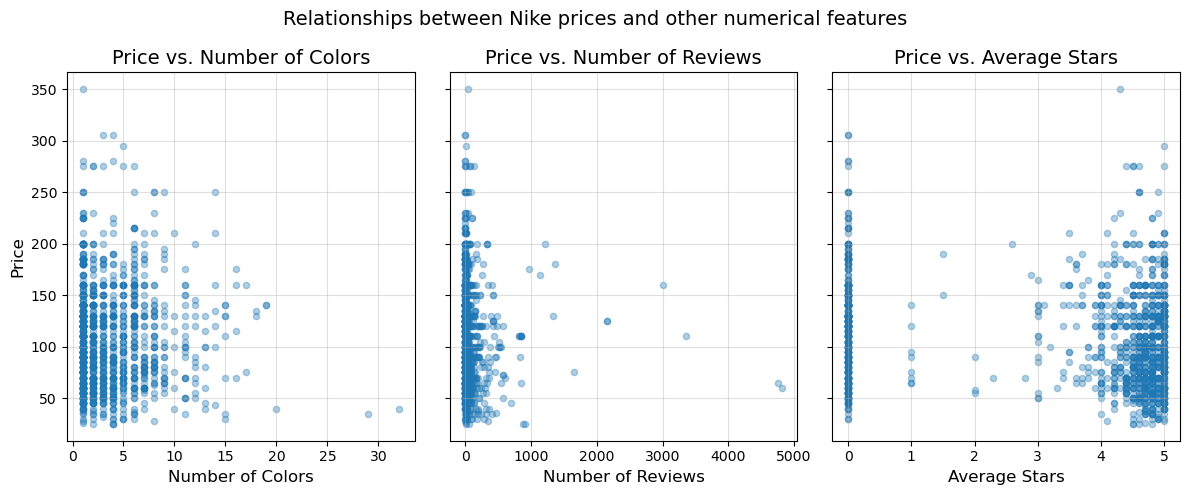

In [15]:
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (12, 5))

fontsize = 14

cols = ["num_colors", "n_reviews", "avg_stars"] 
title_vs_text = ["num_colors", "n_reviews", "avg_stars"]
xlabels = ["Number of Colors", "Number of Reviews", "Average Stars"]

for i, (ax, col, title_vs, xlabel) in enumerate(
    zip(axes, cols, title_vs_text, xlabels)):

    ax.scatter(nike[col], nike["price"], alpha = 0.35, s = 20)
    ax.set_title(f"Price vs. {xlabel}", fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize-2)
    ax.set_ylabel("Price" if i==0 else None, fontsize = fontsize - 2)
    ax.grid(":", alpha = 0.4)

plt.suptitle("Relationships between Nike prices and other numerical features", 
             fontsize = fontsize)
plt.tight_layout()

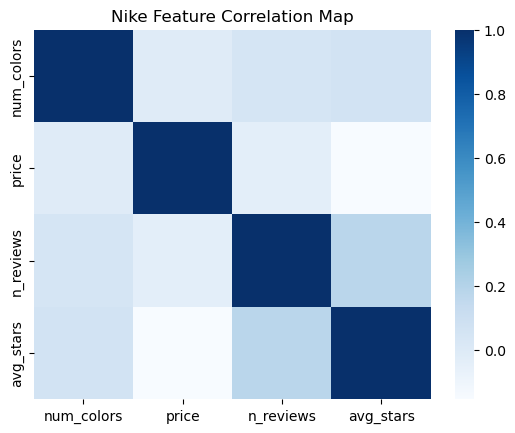

In [17]:
cor = nike.corr()

sns.heatmap(cor, cmap = 'Blues')
plt.title("Nike Feature Correlation Map")
plt.show()

## Plot Categorical Variables

In [6]:
list_label = nike['label'].unique().tolist()
len_label = len(list_label)
print(f'There are {len_label} unique labels which are {list_label}')

There are 10 unique labels which are ['Best Seller', 'Coming Soon', nan, 'Sustainable Materials', 'Member Access', 'Customize', 'Just In', 'Launching in SNKRS', 'Available in SNKRS', 'Sold Out']


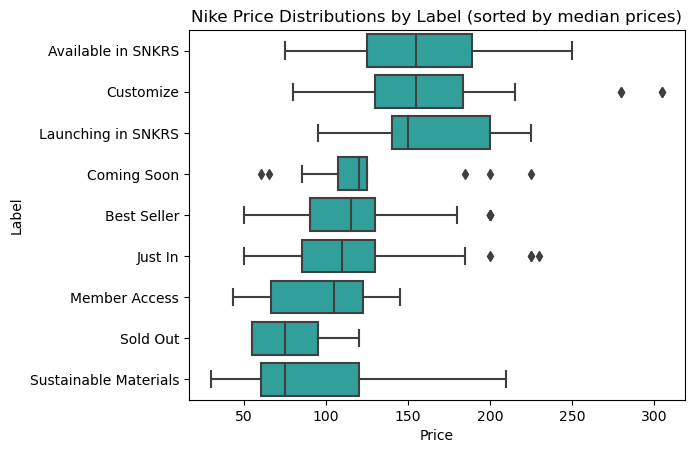

In [19]:
labels_sorted = nike.groupby('label').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data = nike, y = 'label', x = 'price', 
            color = 'lightseagreen', order = labels_sorted.index)
plt.xlabel('Price')
plt.ylabel('Label')
plt.title('Nike Price Distributions by Label (sorted by median prices)')
plt.show()

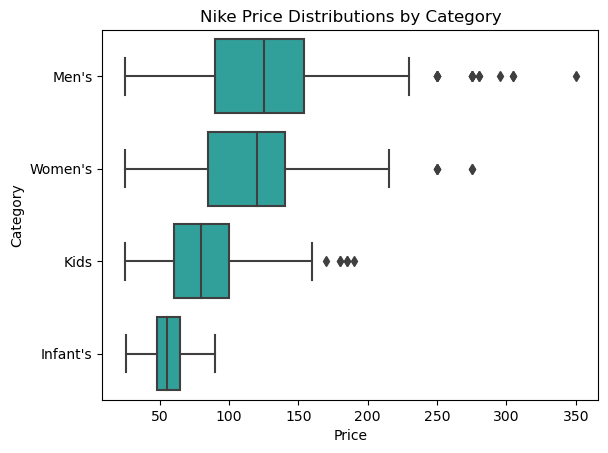

In [98]:
median_price_cat_sorted = nike.groupby('category').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data = nike, y = 'category', x = 'price', 
            color = 'lightseagreen', order = median_price_cat_sorted.index)
plt.xlabel('Price')
plt.ylabel('Category')
plt.title('Nike Price Distributions by Category')
plt.show()

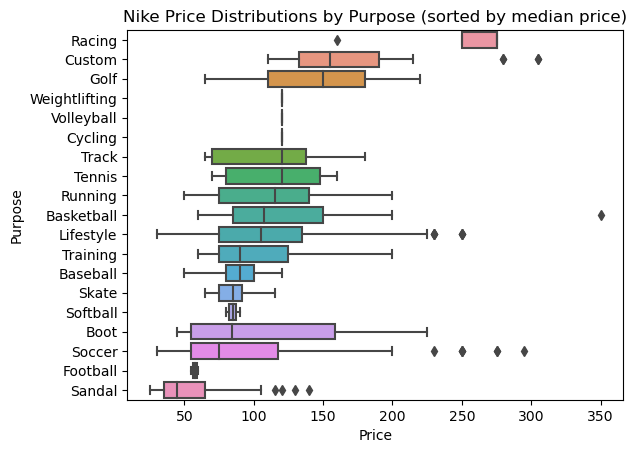

In [100]:
median_price_purpose_sorted = nike.groupby('purpose')['price'].median().sort_values(ascending = False)

# order box plot by median
sns.boxplot(data = nike, y = 'purpose', x = 'price', 
            order = median_price_purpose_sorted.index)
plt.xlabel('Price')
plt.ylabel('Purpose')
plt.title('Nike Price Distributions by Purpose (sorted by median price)')
plt.show()

## Numeric Stats

In [102]:
mean_price = nike["price"].mean() 
mean_noc = nike["num_colors"].mean()
std_price = nike["price"].std() 
std_noc = nike["num_colors"].std()
print(
    "\n"
    f"The mean price is {mean_price:.4f} \n"
    f"The mean number of colors is {mean_noc:.4f} \n"
    f"The Standard Deviation of price is {std_price:.4f}\n"
    f"The Standard Deviation of number of colors is {std_noc:.4f}"
)


The mean price is 108.3433 
The mean number of colors is 3.5271 
The Standard Deviation of price is 47.8272
The Standard Deviation of number of colors is 3.3761


In [103]:
price_min = nike["price"].min()
price_max = nike["price"].max() 
price_range = price_max - price_min 

print(
    f"The range of price for which shoes in our dataset "
    f"is {price_range:,.2f} dolloars. \n\n"
    f"The maximum number of price is {price_max:,.2f}, "
    f"and the minimum is {price_min:,.2f}."
)

The range of price for which shoes in our dataset is 325.00 dolloars. 

The maximum number of price is 350.00, and the minimum is 25.00.


/Users/runlanlana/micromamba/envs/cs109a/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


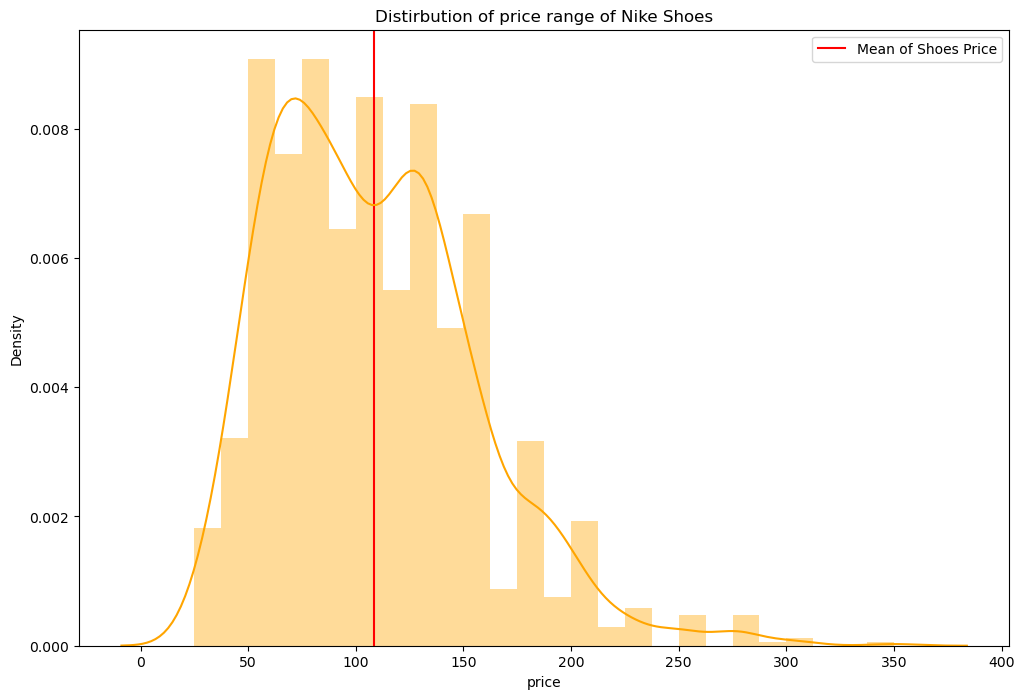

In [104]:
plt.figure(figsize=(12,8))
#ploting the mean
plt.axvline(mean_price, 0, 1, color = 'red', label='Mean of Shoes Price')
sns.distplot(nike['price'], color='orange')
plt.title("Distirbution of price range of Nike Shoes")
plt.legend()
plt.show()

<Figure size 500x300 with 0 Axes>

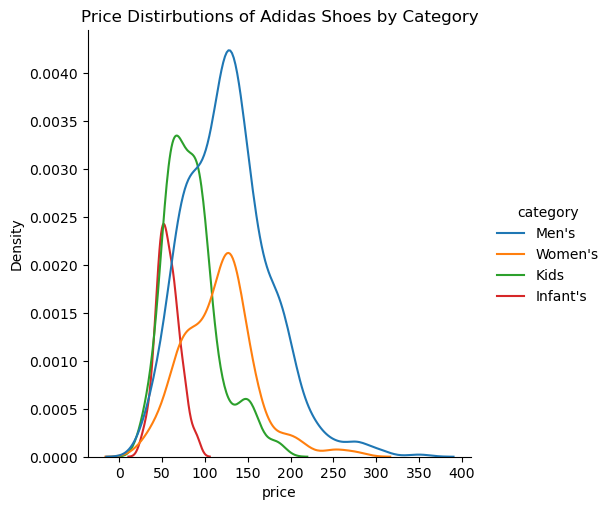

In [105]:
plt.figure(figsize=(5,3))
sns.displot(data = nike, x = "price", hue = "category", kind = "kde")
plt.title("Price Distirbutions of Adidas Shoes by Category")
plt.show()

# NLP Analysis and Preprocessing

## Process Column `description` from Raw Text to Bag-of-Words

In [108]:
df = nike.loc[:, ['title', 'category', 'purpose', 'description', 'price']].copy()  # subset
df['text'] = df['title'].str.cat(df['category'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['purpose'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['description'], sep = '; ', na_rep = '')

df = df[['text', 'price']]
df.dropna(inplace = True)  # dropna
df.head()

,text,price
0,Air Jordan 1 Mid; Men's; Lifestyle; Inspired b...,125.0
1,Nike Blazer Mid '77 Vintage; Women's; Lifestyl...,105.0
2,Nike Dunk Low Retro; Men's; Lifestyle; Created...,110.0
3,Nike Air Force 1 '07; Men's; Lifestyle; The ra...,110.0
4,Air Jordan 12 Retro; Men's; Lifestyle; No need...,200.0


In [111]:
# to lower
df['text'] = df['text'].str.lower()
# remove punctuation
df['text'] = df['text'].str.replace(r'([^\w\s]|_)+', '', regex=True)
# tokenization
df['text'] = df['text'].str.split()
# load list of stop words
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values
# remove stop words from data
df['text'] = df['text'].apply(lambda x: [str(w) for w in x if w not in stopwords])
# create a dictionary (or Series) with the counts of each unique vocab word
vocab_counts = df['text'].explode().value_counts()

In [112]:
# define vocabulary
# list of unique words occuring at least 5 times in the dataset
min_count = 5
vocab = [k for k,v in vocab_counts.items() if v >= 5]

In [113]:
print(f"We have {len(vocab):,} unique words in our reduced, corpus vocabulary.")

We have 1,514 unique words in our reduced, corpus vocabulary.


In [114]:
# remove low-occurance words
df['text'] = df['text'].apply(lambda x: [w for w in x if w in vocab])

In [115]:
# bag of words representation
# list of Counters
# each Counter containing word counts for each row in the DataFrame
counts = df['text'].apply(Counter).to_list()

In [116]:
# Create bag-of-words df from list of dictionaries
bow_df = pd.DataFrame(counts).fillna(0).astype(int)

## Make `price` Categorical with Binning

In [117]:
df.reset_index(drop=True, inplace=True)
# combine what is effectively our X and y into a single DataFrame
df_processed = pd.concat([bow_df, df['price']], axis=1)
df_processed.head()

,air,jordan,1,mid,mens,lifestyle,inspired,original,aj1,offers,...,artisan,coating,slides,decades,internationalist,eyestays,pink,ispa,guo,price
0,2,2,2,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,125.0
1,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,105.0
2,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,110.0
3,2,0,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,110.0
4,2,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,200.0


In [118]:
# split price into bins to make it categorical
df_processed['price'] = pd.cut(df_processed['price'], bins = 5)
df_processed['price'].unique()

[(90.0, 155.0], (155.0, 220.0], (24.675, 90.0], (285.0, 350.0], (220.0, 285.0]]
Categories (5, interval[float64, right]): [(24.675, 90.0] < (90.0, 155.0] < (155.0, 220.0] < (220.0, 285.0] < (285.0, 350.0]]

In [31]:
# df_processed['price'] = df_processed['price'].astype('string')

## Naive Bayes Model of `price ~ bag_of_words(description)`

In [119]:
df_processed1 = df_processed.copy()
df_processed1['price'] = df_processed1['price'].astype('string')

In [120]:
X_train, X_test, y_train, y_test = train_test_split(df_processed1.drop('price', axis = 1),
                                                    df_processed1['price'], 
                                                    test_size = 0.2, random_state = 109)

In [121]:
mnb = MultinomialNB().fit(X_train, y_train)

In [122]:
mnb.score(X_test, y_test)

0.7335766423357665

***Feature importance for each class:***

In [123]:
# 5 brackets
y_train.value_counts(sort=False)

(24.675, 90.0]    467
(90.0, 155.0]     457
(155.0, 220.0]    143
(220.0, 285.0]     22
(285.0, 350.0]      3
Name: price, dtype: Int64

In [124]:
# get most predictive words for each class (bracket 1 and bracket 3)
feat_imp_list = []

for i in range(len(mnb.classes_)):
    class_prob_sorted = mnb.feature_log_prob_[i, :].argsort()[::-1]
    top_pred_words = np.take(bow_df.columns, class_prob_sorted[:])
    feat_imp_list.append(top_pred_words)

**The top 10 most predictive words for each price bracket:**

In [125]:
# prettify list to df
feat_imp_df = pd.DataFrame(np.array(feat_imp_list).T, columns=mnb.classes_)
feat_imp_df = feat_imp_df.loc[:, y_train.value_counts(sort=False).index]  # reorder columns
feat_imp_df.head(10)

,"(24.675, 90.0]","(90.0, 155.0]","(155.0, 220.0]","(220.0, 285.0]","(285.0, 350.0]"
0,nike,nike,air,nike,nike
1,lifestyle,air,nike,air,elite
2,air,lifestyle,mens,mens,mens
3,kids,mens,max,zoom,cleat
4,design,1,lifestyle,next,zoom
5,mens,design,design,elite,touch
6,little,max,zoom,fg,gt
7,max,jordan,jordan,2,soccer
8,1,comfort,cushioning,racing,phantom
9,2,force,feel,lifestyle,made


# Word Feature Importance with Random Forest

In [128]:
rf = RandomForestClassifier(n_estimators = 300, max_depth = 18,
                            min_samples_leaf = 4, random_state = 0).fit(X_train, y_train)
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [129]:
print(f"random forest training score is {random_forest_train_score}")
print(f"random forest test score is {random_forest_test_score}")

random forest training score is 0.8086080586080586
random forest test score is 0.7700729927007299


In [130]:
top_predictors_rf = df_processed.columns[[dtree.tree_.feature[0] for dtree in rf.estimators_]]
top_predictors_rf = pd.Series(top_predictors_rf).value_counts().sort_values(ascending = False)
top_predictors_rf = pd.DataFrame(top_predictors_rf, columns = ['Count'])
print("Top Predictor Counts - Random Forest")
display(top_predictors_rf)

Top Predictor Counts - Random Forest


,Count
bball,12
air,10
easy,10
kiddos,8
little,8
...,...
academy,1
steps,1
iconic,1
top,1


In [131]:
def plot_feature_importance(importance, names, imp_type, selected_top = 10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    plt.figure(figsize=(6,4))
    sns.barplot(x = fi_df.head(selected_top)['feature_importance'], 
                y = fi_df.head(selected_top)['feature_names'],
                color = 'lightseagreen')
    #Add chart labels
    plt.title(imp_type + 'Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    
# Helper function to plot the feature importance (MDI & Perm)
def plot_feature_importance_compare(mdi_imp, perm_imp, colnames):
    plt.xkcd(scale=0.3,randomness=0.6)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

    mdi_importance_sorted_idx = np.argsort(mdi_imp)
    mdi_indices = np.arange(0, len(mdi_imp)) +0.5

    ax1.barh(mdi_indices, result1.importances_mean[mdi_importance_sorted_idx], 
              height = 0.7, color = '#B2D7D0')
    ax1.set_yticks(mdi_indices)
    ax1.set_yticklabels(colnames[mdi_importance_sorted_idx], fontsize = 12)
    ax1.set_ylim((0, len(mdi_imp)))
    ax1.set_xlabel("MDI-Based Feature Importance", fontsize = 16)


    perm_importance_sorted_idx = np.argsort(perm_imp)
    perm_indices = np.arange(0, len(perm_imp)) +0.5
    # difference = perm_imp['importances_mean'] - perm_imp['importances_mean']
    # difference = difference[perm_importance_sorted_idx]

    ax2.barh(perm_indices, perm_imp[perm_importance_sorted_idx], 
              height = 0.7, color = '#EFAEA4')
   
    ax2.set_yticks(perm_indices)
    ax2.set_yticklabels(X.columns[perm_importance_sorted_idx], fontsize = 12)
    ax2.set_ylim((0, len(perm_imp)))
    ax2.set_xlabel("Permutation Feature Importance", fontsize = 16)
    maxlim = max(perm_imp)
    ax2.set_xlim(0, maxlim + 0.015)
    ax1.set_title("MDI-Based Importance", fontsize = 18)
    ax2.set_title("Permutation Importance", fontsize = 18)
    fig.tight_layout()
    plt.show()

**MDI-based and permutation feature importances**

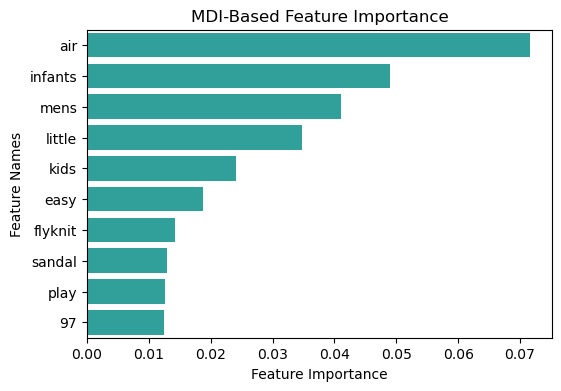

In [133]:
# TODO: X_train cols too big -> takes too long to compute
# perm_imp = permutation_importance(rf, X_train, y_train)['importances_mean']
# plot_feature_importance_compare(rf.feature_importances_, perm_imp, list(X_train.columns))
plot_feature_importance(rf.feature_importances_, X_train.columns, 'MDI-Based ')
# plot_feature_importance(permutation_importance(rf, X_train, y_train), X_train.columns, 'Permutation')

# TFIDF on BOW

**TF-IDF on text column**

### Non text features

In [42]:
# drop NA based on col description
df = nike.dropna(subset=['description']).copy()
df.head(1)

,Unnamed: 0,label,title,subtitle,num_colors,price,reduced_price,url,description,colors,n_reviews,avg_stars
0,0,Best Seller,Air Jordan 1 Mid,Shoes,2.0,125.0,NaN,https://www.nike.com/t/air-jordan-1-mid-shoes-...,"Inspired by the original AJ1, the Air Jordan 1...",Black/White/Fire Red; Black/Black/Black,2161.0,4.9


In [43]:
# subtitle categorical feature - men/women/kids - make that a gender feature
df.subtitle.value_counts()

Men's Shoes                               212
Women's Shoes                             121
Big Kids' Shoes                           117
Little Kids' Shoes                         98
Baby/Toddler Shoes                         86
                                         ... 
Men’s Training Shoes                        1
Men's Duckboot                              1
Women's Easy On/Off Road Running Shoes      1
Women's Slip                                1
Men's Football Cleat                        1
Name: subtitle, Length: 201, dtype: int64

In [44]:
# lower
df['gender'] = df.subtitle.str.lower()

In [45]:
# give NA a category
df['gender'].fillna('other', inplace=True)

In [46]:
# women
df['gender'].replace(regex='.*women.*', value='1', inplace=True)

In [47]:
# men
df['gender'].replace(regex='.*men.*', value='men', inplace=True)

In [48]:
# recover women
df['gender'].replace(regex='1', value='women', inplace=True)

In [49]:
# big kids
df['gender'].replace(regex='^big kids.*', value='big_kids', inplace=True)

In [50]:
# little kids
df['gender'].replace(regex='^little kids.*', value='little_kids', inplace=True)

In [51]:
# baby
df['gender'].replace(regex='^baby.*', value='baby', inplace=True)

In [52]:
# clean up kids
df['gender'].replace(regex='.* kid.*', value='big_kids', inplace=True)
df['gender'].replace(regex='.*crib.*', value='baby', inplace=True)

In [53]:
# other
df.loc[df.gender.str.match('^(?!.*(men|women|big_kids|little_kids|baby)).*$'), 'gender'] = 'other'

In [54]:
# final categories
df.gender.value_counts()

men            411
women          258
other          221
big_kids       216
little_kids    122
baby           112
Name: gender, dtype: int64

### Other non text features

In [55]:
# subset
df_sub = df.loc[:, ['num_colors', 'n_reviews', 'avg_stars', 'gender']].copy()
df_sub.head(3)

,num_colors,n_reviews,avg_stars,gender
0,2.0,2161.0,4.9,other
1,3.0,519.0,4.8,women
2,1.0,7.0,4.6,men


In [56]:
# dummy
df_sub = pd.get_dummies(df_sub)
df_sub.head(3)

,num_colors,n_reviews,avg_stars,gender_baby,gender_big_kids,gender_little_kids,gender_men,gender_other,gender_women
0,2.0,2161.0,4.9,0,0,0,0,1,0
1,3.0,519.0,4.8,0,0,0,0,0,1
2,1.0,7.0,4.6,0,0,0,1,0,0


In [57]:
# prefix all non-text features - to distinguish from BOW words
df_sub.columns = ['feature_' + col for col in df_sub.columns]
df_sub.head(3)

,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women
0,2.0,2161.0,4.9,0,0,0,0,1,0
1,3.0,519.0,4.8,0,0,0,0,0,1
2,1.0,7.0,4.6,0,0,0,1,0,0


### Concatenate with BOW

In [58]:
df_sub.reset_index(drop=True, inplace=True)

In [59]:
df_model = pd.concat([df_processed[['price']], df_sub, df_processed.drop('price', axis=1)], axis=1)

In [60]:
df_model.rename({'price': 'target_price'}, axis=1, inplace=True)

In [61]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women,...,optimal,use,unleash,grass,artisan,coating,slides,decades,eyestays,pink
0,"(90.0, 155.0]",2.0,2161.0,4.9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"(90.0, 155.0]",3.0,519.0,4.8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"(90.0, 155.0]",1.0,7.0,4.6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(90.0, 155.0]",2.0,128.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"(155.0, 220.0]",1.0,333.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### convert `target_price` into integer

In [62]:
# the original labels
df_model['target_price'].value_counts()

(24.675, 90.0]    594
(90.0, 155.0]     556
(155.0, 220.0]    166
(220.0, 285.0]     20
(285.0, 350.0]      4
Name: target_price, dtype: int64

In [63]:
# label to int
df_model['target_price'] = df_model['target_price'].astype('category').cat.codes

In [64]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women,...,optimal,use,unleash,grass,artisan,coating,slides,decades,eyestays,pink
0,1,2.0,2161.0,4.9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3.0,519.0,4.8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,7.0,4.6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2.0,128.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1.0,333.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Note the structure:

- target: `target_price`
- non-text features: `feature_xxx` - 3 numeric, 1 categorical (dummified gender)
- text features from description: put at the end of the df

### Save final df for further modeling

In [65]:
df_model.to_csv('data/nike_model.csv', index=False)

In [66]:
est_df = df_model.loc[:,~df_model.columns.duplicated()]
X = est_df.drop('target_price', axis=1)
Y = est_df.iloc[:, 0].values

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)
Accuracy: 77.88%


In [73]:
features = df_model.columns[1:1435]
importance = model.feature_importances_
len(importance)


1434

Text(0.5, 0, 'Xgboost Feature Importance: Top 20 Most Important Features')

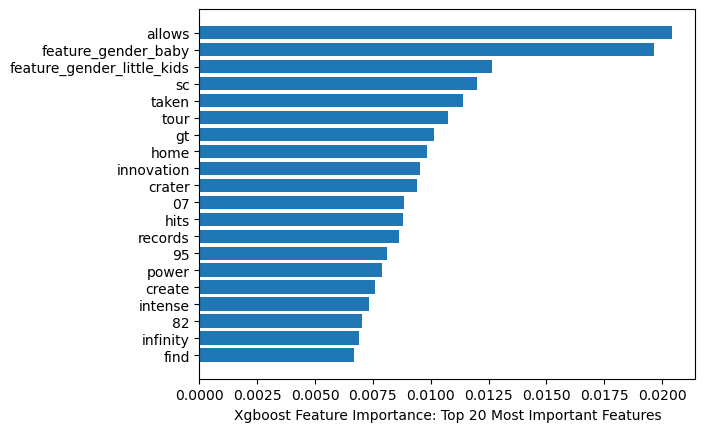

In [68]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(features[sorted_idx][-20:],importance[sorted_idx][-20:])

plt.xlabel("Xgboost Feature Importance: Top 20 Most Important Features")

In [69]:
# TAKES VERY LONG

# perm_importance = permutation_importance(model,X_test,y_test)
# sorted_idx_perm = perm_importance.importances_mean.argsort()
# plt.barh(features[sorted_idx_perm][-20:],perm_importance[sorted_idx_perm][-20:])
# plt.xlabel("Xgboost Permutation Feature Importance: Top 20 Most Important Features")

In [79]:
params = {'boosting':'gbdt','objective': 'multiclass','num_leaves':10,'num_class':1435}
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)

model = lgb.train(params,train_set = lgb_train,valid_sets=lgb_eval,early_stopping_rounds=30)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 279
[LightGBM] [Info] Start training from score -0.890973
[LightGBM] [Info] Start training from score -0.815120
[LightGBM] [Info] Start training from score -2.071668
[LightGBM] [Info] Start training from score -4.026467
[LightGBM] [Info] Start training from score -5.700444
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776


In [87]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred,axis=1)

cr = classification_report(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

print(cr)
pd.crosstab(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       226
           1       0.63      0.81      0.71       159
           2       0.58      0.34      0.43        53
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1

    accuracy                           0.74       443
   macro avg       0.52      0.44      0.46       443
weighted avg       0.75      0.74      0.73       443



/home/devillish_red/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/devillish_red/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/devillish_red/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


col_0,0,1,2,3
row_0,,,,
0,181,42,3,0
1,21,128,10,0
2,5,30,18,0
3,1,2,0,1
4,0,0,0,1


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

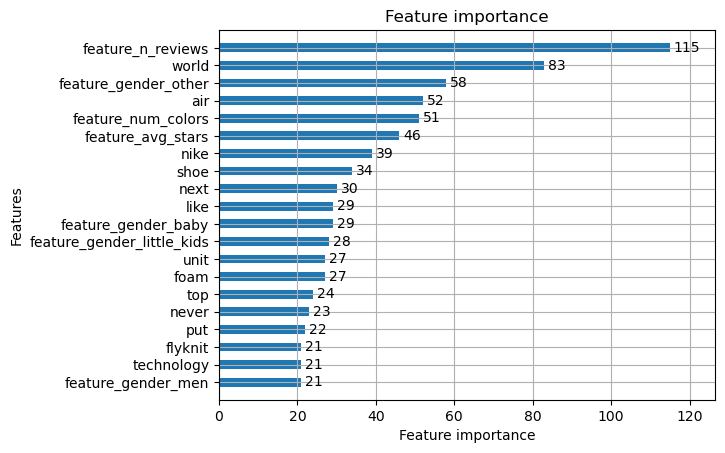

In [83]:
lgb.plot_importance(model,height=.5,max_num_features=20 )